# Feature Importance

In [1]:
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import mannwhitneyu
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_theme(style="whitegrid", context="paper", palette="Greys", font_scale=1.5)

In [2]:
labels = ['statistical_parity', 'equal_opportunity', 'average_odds']
data = pd.read_csv('../data/bias_symptoms_logreg_reduced.csv', index_col=[0,1])
data.index = data.index.droplevel(0)

In [3]:
mlp = MLPClassifier(
    alpha=0.0001,
    hidden_layer_sizes=(50,),
    learning_rate="constant",
    learning_rate_init=0.01,
    max_iter=200,
)
rf = RandomForestClassifier(
    max_depth=10,
    max_features="log2",
    min_samples_leaf=1,
    min_samples_split=10,
    n_estimators=500,
)
xgb = XGBClassifier(
    colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=6, subsample=0.6
)

In [4]:
def train_model(metric):
    mlp.fit(data.drop(columns=labels), data[metric])
    rf.fit(data.drop(columns=labels), data[metric])
    xgb.fit(data.drop(columns=labels), data[metric])
    return mlp, rf, xgb

In [5]:
def plot_importance(result):
    sorted_importances_idx = result['importances_mean'].argsort()
    importances = pd.DataFrame(
        result.importances[sorted_importances_idx].T,
        columns=data.drop(columns=labels).columns[sorted_importances_idx],
    )
    fig, ax = plt.subplots(figsize=(2, 4))
    ax = importances.plot.box(vert=False, whis=10, color="black", ax=ax)
    #ax.axvline(x=0, color="k", linestyle="--")
    # ax.axhline(y=8.5, color="k", linestyle="--")
    ax.set_xlabel("AP Loss")
    return ax

def compute_statistical_difference(result):
    sorted_importances_idx = result["importances_mean"].argsort()
    importances = result.importances[sorted_importances_idx].T
    ris = []
    for i in range(importances.shape[1]):
        find = False
        for j in range(i + 1, importances.shape[1]):
                if not find:
                    test = mannwhitneyu(importances[:, i], importances[:, j])
                    if test[1] < 0.05:
                        print(
                            i+1, j+1,
                            # result["importances_mean"].index[sorted_importances_idx[i]],
                            # result["importances_mean"].index[sorted_importances_idx[j]],
                        )
                        find = True
                        ris.append((i+1, j+1))
    return ris

def compute_permutation(metric, xgb, rf, mlp):
    result_xgb = permutation_importance(
        xgb,
        data.drop(columns=labels),
        data[metric],
        scoring="average_precision",
        n_jobs=-1,
        n_repeats=10,
    )
    result_rf = permutation_importance(
        rf,
        data.drop(columns=labels),
        data[metric],
        scoring="average_precision",
        n_jobs=-1,
        n_repeats=10,
    )
    result_mlp = permutation_importance(
        mlp,
        data.drop(columns=labels),
        data[metric],
        scoring="average_precision",
        n_jobs=-1,
        n_repeats=10,
    )
    return result_xgb, result_rf, result_mlp

## Statistical Parity

In [6]:
mlp_sp, rf_sp, xgb_sp = train_model('statistical_parity')

In [7]:
result_xgb_sp, result_rf_sp, result_mlp_sp = compute_permutation('statistical_parity', xgb_sp, rf_sp, mlp_sp)

In [9]:
stats = compute_statistical_difference(result_xgb_sp)

1 2
2 5
3 5
4 5
5 6
6 7
7 8
8 9
9 10
10 11
11 12
12 13


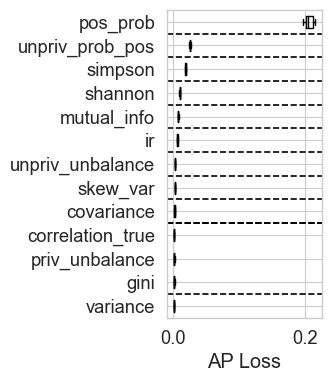

In [12]:
ax_xgb = plot_importance(result_xgb_sp)
# tick_labels = [
#         "Prob Diff",
#         "Simpson",
#         "UPP",
#         "Kurtosis",
#         "Mutual Info",
#         "Shannon",
#         "Kendall Tau",
#         "Unpriv Unbal",
#         "PPP",
#         "Priv Unbal",
#         "Skewness",
#         "Gini",
#         "IR",
#     ]
# tick_labels.reverse()
# ax_xgb.set_yticklabels(tick_labels)
for i, (a, b) in enumerate(stats):
    ax_xgb.axhline(y=b-0.5, color="k", linestyle="--")

plt.savefig('figs/perm_importance_xgb_sp.pdf', bbox_inches='tight')

In [14]:
stats_rf = compute_statistical_difference(result_rf_sp)

1 3
2 4
3 4
4 5
5 7
6 7
7 8
8 9
9 10
10 11
11 12
12 13


NameError: name 'stats_rf' is not defined

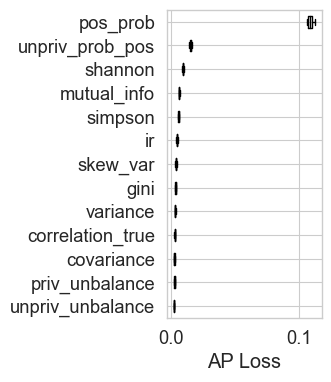

In [13]:
ax_rf = plot_importance(result_rf_sp)
for i, (a, b) in enumerate(stats_rf):
    ax_rf.axhline(y=b - 0.5, color="k", linestyle="--")
# tick_labels = [
#     "Prob Diff",
#     "UPP",
#     "Shannon",
#     "Mutual Info",
#     "Simpson",
#     "Kendall Tau",
#     "Kurtosis",
#     "IR",
#     "PPP",
#     "Skewness",
#     "Gini",
#     "Unpriv Unbal",
#     "Priv Unbal",
# ]
# tick_labels.reverse()
# ax_rf.set_yticklabels(tick_labels)


plt.savefig("figs/perm_importance_rf_sp.pdf", bbox_inches="tight")

In [49]:
stats_mlp = compute_statistical_difference(result_mlp_sp)

1 2
2 3
3 4
4 5
5 6
6 8
7 8
8 9
9 10
10 12
11 12
12 13


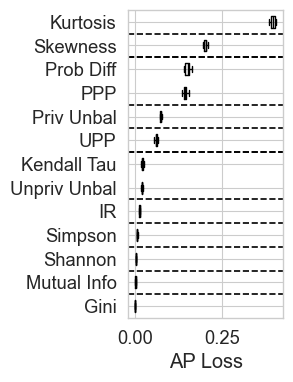

In [50]:
ax_mlp = plot_importance(result_mlp_sp)
for i, (a, b) in enumerate(stats_mlp):
    ax_mlp.axhline(y=b - 0.5, color="k", linestyle="--")
tick_labels = [
    "Kurtosis",
    "Skewness",
    "Prob Diff",
    "PPP",
    "Priv Unbal",
    "UPP",
    "Kendall Tau",
    "Unpriv Unbal",
    "IR",
    "Simpson",
    "Shannon",
    "Mutual Info",
    "Gini",
]
tick_labels.reverse()
ax_mlp.set_yticklabels(tick_labels)
plt.savefig("figs/perm_importance_mlp_sp.pdf", bbox_inches="tight")

## Equal Opportunity

In [15]:
mlp_eo, rf_eo, xgb_eo = train_model("equal_opportunity")

In [16]:
result_xgb_sp, result_rf_sp, result_mlp_sp = compute_permutation(
    "equal_opportunity", xgb_sp, rf_sp, mlp_sp
)

In [17]:
stats = compute_statistical_difference(result_xgb_sp)

1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
10 11
11 12


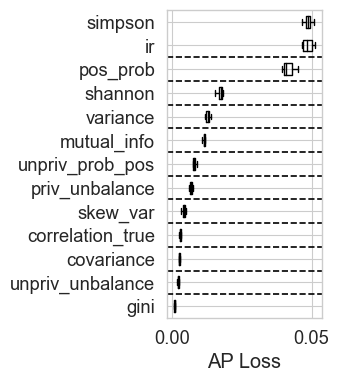

In [18]:
ax_xgb = plot_importance(result_xgb_sp)
# tick_labels = [
#         "Kurtosis",
#         "Simpson",
#         "Prob Diff",
#         "Mutual Info",
#         "Shannon",
#         "UPP",
#         "Kendall Tau",
#         "IR",
#         "PPP",
#         "Priv Unbal",
#         "Skewness",
#         "Unpriv Unbal",
#         "Gini",
#     ]
# tick_labels.reverse()
# ax_xgb.set_yticklabels(tick_labels)
for i, (a, b) in enumerate(stats):
    ax_xgb.axhline(y=b-0.5, color="k", linestyle="--")

plt.savefig('figs/perm_importance_xgb_eo.pdf', bbox_inches='tight')

In [55]:
stats_rf = compute_statistical_difference(result_rf_sp)

1 2
2 4
3 4
4 6
5 6
6 7
7 8
8 9
9 10
10 11
11 12


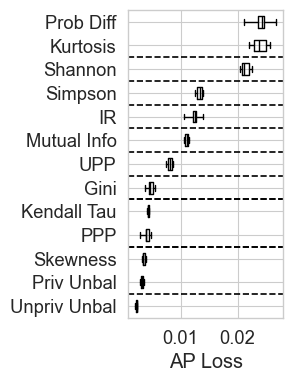

In [56]:
ax_rf = plot_importance(result_rf_sp)
for i, (a, b) in enumerate(stats_rf):
    ax_rf.axhline(y=b - 0.5, color="k", linestyle="--")
tick_labels = [
    "Prob Diff",
    "Kurtosis",
    "Shannon",
    "Simpson",
    "IR",
    "Mutual Info",
    "UPP",
    "Gini",
    "Kendall Tau",
    "PPP",
    "Skewness",
    "Priv Unbal",
    "Unpriv Unbal",
]
tick_labels.reverse()
ax_rf.set_yticklabels(tick_labels)

plt.savefig("figs/perm_importance_rf_eo.pdf", bbox_inches="tight")

In [57]:
stats_mlp = compute_statistical_difference(result_mlp_sp)

1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
10 11
11 12
12 13


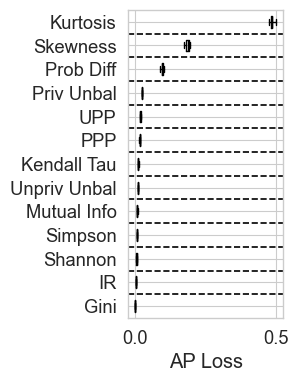

In [58]:
ax_mlp = plot_importance(result_mlp_sp)
for i, (a, b) in enumerate(stats_mlp):
    ax_mlp.axhline(y=b - 0.5, color="k", linestyle="--")
tick_labels = [
    "Kurtosis",
    "Skewness",
    "Prob Diff",
    "Priv Unbal",
    "UPP",
    "PPP",
    "Kendall Tau",
    "Unpriv Unbal",
    "Mutual Info",
    "Simpson",
    "Shannon",
    "IR",
    "Gini",
]
tick_labels.reverse()
ax_mlp.set_yticklabels(tick_labels)
plt.savefig("figs/perm_importance_mlp_eo.pdf", bbox_inches="tight")

## Average Odds

In [19]:
mlp_ao, rf_ao, xgb_ao = train_model("average_odds")

In [20]:
result_xgb_sp, result_rf_sp, result_mlp_sp = compute_permutation(
    "average_odds", xgb_sp, rf_sp, mlp_sp
)

In [21]:
stats = compute_statistical_difference(result_xgb_sp)

1 2
2 3
3 4
4 6
5 6
6 7
7 8
8 9
9 10
10 11
11 13
12 13


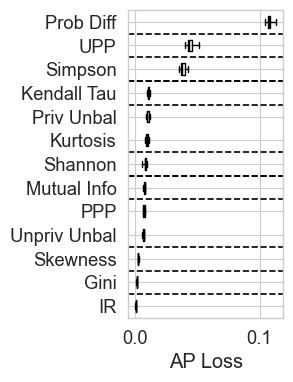

In [62]:
ax_xgb = plot_importance(result_xgb_sp)
tick_labels = [
        "Prob Diff",
        "UPP",
        "Simpson",
        "Kendall Tau",
        "Priv Unbal",
        "Kurtosis",
        "Shannon",
        "Mutual Info",
        "PPP",
        "Unpriv Unbal",
        "Skewness",
        "Gini",
        "IR",
    ]
tick_labels.reverse()
ax_xgb.set_yticklabels(tick_labels)
for i, (a, b) in enumerate(stats):
    ax_xgb.axhline(y=b-0.5, color="k", linestyle="--")

plt.savefig('figs/perm_importance_xgb_ao.pdf', bbox_inches='tight')

In [63]:
stats_rf = compute_statistical_difference(result_rf_sp)

1 2
2 3
3 6
4 6
5 7
6 7
7 8
8 10
9 10
10 11
11 12
12 13


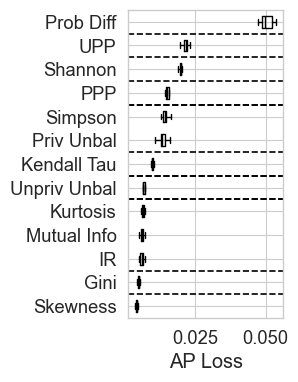

In [64]:
ax_rf = plot_importance(result_rf_sp)
for i, (a, b) in enumerate(stats_rf):
    ax_rf.axhline(y=b - 0.5, color="k", linestyle="--")
tick_labels = [
    "Prob Diff",
    "UPP",
    "Shannon",
    "PPP",
    "Simpson",
    "Priv Unbal",
    "Kendall Tau",
    "Unpriv Unbal",
    "Kurtosis",
    "Mutual Info",
    "IR",
    "Gini",
    "Skewness",
]
tick_labels.reverse()
ax_rf.set_yticklabels(tick_labels)

plt.savefig("figs/perm_importance_rf_ao.pdf", bbox_inches="tight")

In [65]:
stats_mlp = compute_statistical_difference(result_mlp_sp)

1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
10 11
11 12
12 13


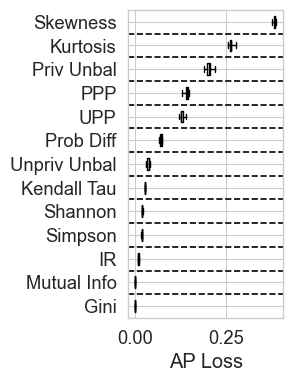

In [66]:
ax_mlp = plot_importance(result_mlp_sp)
for i, (a, b) in enumerate(stats_mlp):
    ax_mlp.axhline(y=b - 0.5, color="k", linestyle="--")
tick_labels = [
    "Skewness",
    "Kurtosis",
    "Priv Unbal",
    "PPP",
    "UPP",
    "Prob Diff",
    "Unpriv Unbal",
    "Kendall Tau",
    "Shannon",
    "Simpson",
    "IR",
    "Mutual Info",
    "Gini",
]
tick_labels.reverse()
ax_mlp.set_yticklabels(tick_labels)
plt.savefig("figs/perm_importance_mlp_ao.pdf", bbox_inches="tight")